# Human-in-the-Loop

We've tested two different email assistant, both of which can triage emails and use tools to respond to them. But do we actually *trust* them to manage our inbox? Few would trust an AI to manage their inbox without some human oversight immediately, which is why human-in-the-loop (HITL) is a critical pattern for many agent systems.

![overview-img](img/overview_hitl.png)

## LangGraph Interrupts

The HITL (Human-In-The-Loop) pattern is useful for applications where decisions require human validation. LangGraph provides built-in support for this through its [interrupt mechanism](https://langchain-ai.github.io/langgraph/concepts/interrupts/), allowing us to pause execution of an agent and request human input when needed. Let's add HITL to our email assistant after specific tools are called.

### Simple Interrupt Example

First, let's just show a simple example for how to use the `interrupt` function. Assume we want a simple agent that can ask the user a question and then use that information. The `interrupt` function can be used for this purpose:

```
location = interrupt(ask.question)
```

When this line executes:
1. It raises a `GraphInterrupt` exception, which pauses the graph execution
2. It surfaces the value passed in (`ask.question`) to the client TODO: explain the client
3. Execution stops at this point until resumed 
4. When resumed, the function returns the value provided by the human

Here's a minimal example of how to implement this using `interrupt`:

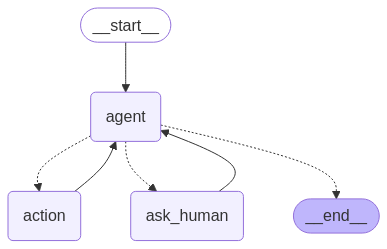

In [1]:
from pydantic import BaseModel
from langgraph.graph import MessagesState, START, END, StateGraph
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.types import Command, interrupt
from IPython.display import Image, display

@tool
def search(query: str):
    """Call to surf the web."""
    return f"I looked up: {query}. Result: It's sunny in San Francisco."

# We can define a tool definition for `ask_human`
class AskHuman(BaseModel):
    """Ask the human a question"""
    question: str

tools = [search, AskHuman]
tool_node = ToolNode([search])

# Set up the model
from langchain.chat_models import init_chat_model
llm = init_chat_model("openai:gpt-4o", temperature=0.0)
llm_with_tools = llm.bind_tools(tools)

# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # If tool call is asking Human, we return that node
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "action"

def call_model(state):
    messages = state["messages"]
    message = llm_with_tools.invoke(messages)
    return {"messages": [message]}

def ask_human(state):
    # Get the tool call ID 
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    # Get the AskHuman schema
    ask = AskHuman.model_validate(state["messages"][-1].tool_calls[0]["args"])
    # Interrupt the graph with the question from the AskHuman schema
    location = interrupt(ask.question)
    # Create a tool message once the user has responded with the location
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": location}]
    return {"messages": tool_message}

# Define a new graph
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

# Set the entrypoint as `agent`
workflow.add_edge(START, "agent")
# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)
# We now add a normal edge from `tools` to `agent`.
workflow.add_edge("action", "agent")
workflow.add_edge("ask_human", "agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
# Compile the workflow
app = workflow.compile(checkpointer=memory)
# Draw the graph
display(Image(app.get_graph().draw_mermaid_png()))

Now, we ask the user where they are and look up the weather there:

In [2]:
config = {"configurable": {"thread_id": "1"}}
messages = [{"role": "user", "content": "Ask the user where they are, then look up the weather there"}]
for event in app.stream({"messages": messages}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Ask the user where they are, then look up the weather there
================================== Ai Message ==================================
Tool Calls:
  AskHuman (call_eATaMXu32mxJS0kIxjzcUnvq)
 Call ID: call_eATaMXu32mxJS0kIxjzcUnvq
  Args:
    question: Where are you located?


You can see that our graph got interrupted inside the `ask_human` node. It is now waiting for a location to be provided. You also notice that we use the [checkpointer](https://langchain-ai.github.io/langgraph/concepts/memory/#short-term-memory) to persist the state of the graph after the interrupt. This allows us to resume execution from the same state after the human has responded.

In [3]:
app.get_state(config).next

('ask_human',)

### Using Command to Resume Execution

After an interrupt, we need a way to continue execution. This is where the `Command` interface comes in. [The `Command` object has several powerful capabilities](https://langchain-ai.github.io/langgraph/how-tos/command/):
- `resume`: Provides the value to return from the interrupt call
- `goto`: Specifies which node to route to next
- `update`: Modifies the state before continuing execution
- `graph`: Controls navigation between parent and child graphs

In this case, the `Command` object serves two crucial purposes:
1. It provides the value to be returned from the `interrupt` call
2. It controls the flow of execution in the graph

In [4]:
# Resume execution with the value "san francisco"
for event in app.stream(Command(resume="san francisco"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  AskHuman (call_eATaMXu32mxJS0kIxjzcUnvq)
 Call ID: call_eATaMXu32mxJS0kIxjzcUnvq
  Args:
    question: Where are you located?
================================= Tool Message =================================

san francisco
================================== Ai Message ==================================
Tool Calls:
  search (call_AbXkvTDR2do3hfNOb9vTXRqA)
 Call ID: call_AbXkvTDR2do3hfNOb9vTXRqA
  Args:
    query: San Francisco weather
================================= Tool Message =================================
Name: search

I looked up: San Francisco weather. Result: It's sunny in San Francisco.
================================== Ai Message ==================================

The weather in San Francisco is currently sunny.


## Agent Inbox

While we can implement basic human-in-the-loop functionality using `interrupt` calls and `Command` responses with the SDK, as shown above, this doesn't really scale well if we want to process a large number of emails and a variety of different actions. Our email assistant requires several types of human-in-the-loop interactions:

1. **Email Triage Review**:
   - When an email is classified as "NOTIFY," humans should verify this classification
   - Users should be able to accept the classification or provide feedback on how it should be classified

2. **Email Response Review**:
   - Before sending responses to important emails, humans should review the content
   - Users need options to edit the draft, accept it as-is, provide feedback, or reject it entirely

3. **Meeting Scheduling Review**:
   - When the assistant proposes scheduling a meeting, humans should verify the details
   - Users should be able to modify attendees, duration, date/time before accepting

In general, any significant action (sending emails, scheduling meetings) requires human approval. Some low-risk tools (like calendar availability checks) can run without interruption. Of course, this is entirely dependent on the application and the risk of the action.

### Agent Inbox: A Purpose-Built HITL Interface

With this in mind, we built a simple interface for human-in-the-loop called [Agent Inbox](https://github.com/langchain-ai/agent-inbox) that allows us to review and approve or reject actions taken by LangGraph agents. Agent Inbox provides:

1. **Structured Interaction Types**:
   - `accept`: Approve the agent's action and continue
   - `edit`: Modify the agent's proposed action before execution
   - `response`: Provide feedback or answers without editing
   - `ignore`: Reject the agent's action entirely

2. **Rich Content Display**:
   - Render (email) content in a readable format
   - Support markdown for structured information presentation

3. **Consistent User Experience**:
   - Notification system for pending reviews
   - Action buttons that match the allowed interaction types
   - Thread-based organization of agent activities

4. **Easy Integration with LangGraph**:
   - Simple connection to local or hosted LangGraph deployments
   - Compatible with LangGraph's interrupt mechanism
   - No complex frontend development required

### Integration with LangGraph's interrupt() Function

Agent Inbox integrates seamlessly with LangGraph's `interrupt()` function. The integration works like this:

1. **Request Structure**: We structure an interrupt request with specific fields:
   ```python
   request = {
       "action_request": {
           "action": "write_email",  # Name of the tool to call
           "args": {"to": "john@example.com", "subject": "Meeting", "content": "..."}  # Action parameters
       },
       "config": {
           "allow_ignore": True,   # Can dismiss the action
           "allow_respond": True,  # Can provide feedback
           "allow_edit": True,     # Can modify the action
           "allow_accept": True,   # Can approve the action
       },
       "description": "Email content to display..." # Context shown to the user
   }
   ```

2. **Passing to interrupt()**: We pass this request to the interrupt function:
   ```python
   response = interrupt([request])[0]  # Can batch multiple requests
   ```

3. **User Interaction**: Agent Inbox shows the request and collects the user's response

4. **Handling Responses**: When execution resumes, we receive a structured `response`:
   ```python
   if response["type"] == "accept":
       # Execute the tool with original args
   elif response["type"] == "edit":
       # Execute with edited args from response["args"]
   elif response["type"] == "ignore":
       # Skip execution
   elif response["type"] == "response":
       # Process feedback from response["args"]
   ```

This structured approach allows our email assistant to collect precise human input at critical decision points while maintaining a consistent user experience.

## Email Assistant with Human-in-the-Loop

Now that we understand both the interrupt mechanism and Agent Inbox, let's look at our email assistant implementation with human-in-the-loop. This implementation brings together all the concepts we've discussed:

1. It uses the `interrupt` function to pause execution at key decision points
2. It structures interrupt requests specifically for Agent Inbox
3. It processes different response types from human reviewers
4. It integrates these HITL capabilities into a full email processing workflow

We'll instrument each of these human-in-the-loop capabilities into our email assistant. Then, in the next notebook, we'll add in memory!

![overview-img](img/HITL_flow.png)

In [5]:
%cd ..
%load_ext autoreload
%autoreload 2

/Users/rlm/Desktop/Code/interrupt_workshop


In [6]:
from typing import Literal
from pydantic import BaseModel

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command

from email_assistant.prompts import triage_system_prompt, triage_user_prompt, agent_system_prompt_hitl, default_background, default_triage_instructions, default_response_preferences, default_cal_preferences
from email_assistant.schemas import State, RouterSchema, StateInput
from email_assistant.utils import parse_email, format_for_display, format_email_markdown

# Agent tools 
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: str, start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled on {preferred_day} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

@tool
class Question(BaseModel):
      """Question to ask user."""
      content: str
    
@tool
class Done(BaseModel):
      """E-mail has been sent."""
      done: bool

# All tools available to the agent
tools = [
    write_email, 
    schedule_meeting, 
    check_calendar_availability, 
    Question, 
    Done,
]

tools_by_name = {tool.name: tool for tool in tools}

# Initialize the LLM for use with router / structured output
llm = init_chat_model("openai:gpt-4o", temperature=0.0)
llm_router = llm.with_structured_output(RouterSchema) 

# Initialize the LLM, enforcing tool use (of any available tools) for agent
llm = init_chat_model("openai:gpt-4o", tool_choice="required", temperature=0.0)
llm_with_tools = llm.bind_tools(tools)

/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_62536/952962973.py:61: UserWarning: WARNING! tool_choice is not default parameter.
                tool_choice was transferred to model_kwargs.
                Please confirm that tool_choice is what you intended.
  llm = init_chat_model("openai:gpt-4o", tool_choice="required", temperature=0.0)


### Nodes of the Email Assistant

Our email assistant has several key nodes that handle different aspects of the workflow:

1. **triage_router**: This node is responsible for analyzing incoming emails and classifying them into three categories:
   - **RESPOND**: Emails that require a response from the assistant.
   - **NOTIFY**: Important emails that don't need a response but should be brought to the user's attention.
   - **IGNORE**: Low-priority emails that can be safely ignored.
   
   The router uses a structured output LLM to make this classification and then routes to the appropriate next node based on its decision.

2. **triage_interrupt_handler**: When an email is classified as "notify," this handler creates an interrupt to display the email in Agent Inbox and collect human feedback. This allows users to:
   - Confirm the notification classification
   - Provide feedback on how they would prefer similar emails to be classified in the future
   
   This feedback loop is crucial for improving the assistant's classification over time.

3. **llm_call**: This node invokes the LLM with the available tools to decide how to respond to an email. The LLM might decide to:
   - Draft a response email
   - Schedule a meeting
   - Ask the user a question
   - Or mark the email as done

Each of these nodes plays a specific role in the overall email processing workflow.

In [7]:
# Nodes 
def triage_router(state: State) -> Command[Literal["triage_interrupt_handler", "response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore.

    The triage step prevents the assistant from wasting time on:
    - Marketing emails and spam
    - Company-wide announcements
    - Messages meant for other teams
    """

    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])
    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Format system prompt with background and triage instructions
    system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=default_triage_instructions
    )

    # Run the router LLM
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    # Decision
    classification = result.classification

    # Process the classification decision
    if classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        # Next node
        goto = "response_agent"
        # Update the state
        update = {
            "classification_decision": result.classification,
            "messages": [{"role": "user",
                            "content": f"Respond to the email: {email_markdown}"
                        }],
        }
    elif classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")

        # Next node
        goto = END
        # Update the state
        update = {
            "classification_decision": classification,
        }

    elif classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information") 

        # Next node
        goto = "triage_interrupt_handler"
        # Update the state
        update = {
            "classification_decision": classification,
        }

    else:
        raise ValueError(f"Invalid classification: {classification}")
    return Command(goto=goto, update=update)

def triage_interrupt_handler(state: State) -> Command[Literal["response_agent", "__end__"]]:
    """Handles interrupts from the triage step"""
    
    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Create messages
    messages = [{"role": "user",
                "content": f"Email to notify user about: {email_markdown}"
                }]

    # Create interrupt for Agent Inbox
    request = {
        "action_request": {
            "action": f"Email Assistant: {state['classification_decision']}",
            "args": {}
        },
        "config": {
            "allow_ignore": True,  
            "allow_respond": True, 
            "allow_edit": False, 
            "allow_accept": False,  
        },
        # Email to show in Agent Inbox
        "description": email_markdown,
    }

    # Agent Inbox responds with a list  
    response = interrupt([request])[0]

    # If user provides feedback, go to response agent and use feedback to respond to email   
    if response["type"] == "response":
        # Add feedback to messages 
        user_input = response["args"]
        # Used by the response agent
        messages.append({"role": "user",
                        "content": f"User wants to reply to the email. Use this feedback to respond: {user_input}"
                        })
        # Go to response agent
        goto = "response_agent"

    # If user ignores email, go to END
    elif response["type"] == "ignore":
        goto = END

    # Catch all other responses
    else:
        raise ValueError(f"Invalid response: {response}")

    # Update the state 
    update = {
        "messages": messages,
    }

    return Command(goto=goto, update=update)

def llm_call(state: State):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    {"role": "system", "content": agent_system_prompt_hitl.format(background=default_background,
                                                                                  response_preferences=default_response_preferences, 
                                                                                  cal_preferences=default_cal_preferences)}
                ]
                + state["messages"]
            )
        ]
    }

### The interrupt_handler

The `interrupt_handler` is the core HITL component of our response agent. Its job is to examine the tool calls that the LLM wants to make and determine which ones need human review before execution. Here's how it works:

1. **Tool Selection**: The handler maintains a list of "HITL tools" that require human approval:
   - `write_email`: Since sending emails has significant external impact
   - `schedule_meeting`: Since scheduling meetings affects calendars
   - `Question`: Since asking users questions requires direct interaction

2. **Direct Execution**: Tools not in the HITL list (like `check_calendar_availability`) are executed immediately without interruption. This allows low-risk operations to proceed automatically.

3. **Context Preparation**: For tools requiring review, the handler:
   - Retrieves the original email for context
   - Formats the tool call details for clear display
   - Configures which interaction types are allowed for each tool type

4. **Interrupt Creation**: The handler creates a structured interrupt request with:
   - The action name and arguments
   - Configuration for allowed interaction types
   - A description that includes both the original email and the proposed action

5. **Response Processing**: After the interrupt, the handler processes the human response:
   - **Accept**: Executes the tool with original arguments
   - **Edit**: Updates the tool call with edited arguments and then executes
   - **Ignore**: Cancels the tool execution
   - **Response**: Records feedback without execution

This handler ensures humans have oversight of all significant actions while allowing routine operations to proceed automatically. The ability to edit tool arguments (like email content or meeting details) gives users precise control over the assistant's actions.

In [8]:
def interrupt_handler(state: State):
    """Creates an interrupt for human review of tool calls"""
    
    # Store messages
    result = []

    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        
        # Allowed tools for HITL
        hitl_tools = ["write_email", "schedule_meeting", "Question"]
        
        # If tool is not in our HITL list, execute it directly without interruption
        if tool_call["name"] not in hitl_tools:

            # Execute search_memory and other tools without interruption
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
            continue
            
        # Get original email from email_input in state
        email_input = state["email_input"]
        author, to, subject, email_thread = parse_email(email_input)
        original_email_markdown = format_email_markdown(subject, author, to, email_thread)
        
        # Format tool call for display and prepend the original email
        tool_display = format_for_display(state, tool_call)
        description = original_email_markdown + tool_display

        # Configure what actions are allowed in Agent Inbox
        if tool_call["name"] == "write_email":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "schedule_meeting":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "Question":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": False,
                "allow_accept": False,
            }
        else:
            raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Create the interrupt request
        request = {
            "action_request": {
                "action": tool_call["name"],
                "args": tool_call["args"]
            },
            "config": config,
            "description": description,
        }

        # Send to Agent Inbox and wait for response
        response = interrupt([request])[0]

        # Handle the responses 
        if response["type"] == "accept":

            # Execute the tool with original args
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
                        
        elif response["type"] == "edit":

            # Tool selection 
            tool = tools_by_name[tool_call["name"]]
            
            # Get edited args from Agent Inbox
            edited_args = response["args"]["args"]

            # Update the write_email tool call with the edited content from Agent Inbox
            if tool_call["name"] == "write_email":
                
                # Update the AI message's tool call with edited content (reference to the message in the state)
                ai_message = state["messages"][-1]
                current_id = tool_call["id"]
                
                # Replace the original tool call with the edited one (any changes made to this reference affect the original object in the state)
                ai_message.tool_calls = [tc for tc in ai_message.tool_calls if tc["id"] != current_id] + [
                    {"type": "tool_call", "name": tool_call["name"], "args": edited_args, "id": current_id}
                ]
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})
            
            # Update the schedule_meeting tool call with the edited content from Agent Inbox
            elif tool_call["name"] == "schedule_meeting":
                
                # Update the AI message's tool call with edited content
                ai_message = state["messages"][-1]
                current_id = tool_call["id"]
                
                # Replace the original tool call with the edited one
                ai_message.tool_calls = [tc for tc in ai_message.tool_calls if tc["id"] != current_id] + [
                    {"type": "tool_call", "name": tool_call["name"], "args": edited_args, "id": current_id}
                ]
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})
            
            # Catch all other tool calls
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "ignore":
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this email draft. Call the 'Done' tool to end the email assistant workflow.", "tool_call_id": tool_call["id"]})
            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this calendar meeting draft. Call the 'write_email' tool to respond, but don't include the meeting details in the email.", "tool_call_id": tool_call["id"]})
            elif tool_call["name"] == "Question":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this question. Proceed with the context that you have and don't ask the user any more questions.", "tool_call_id": tool_call["id"]})
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")
            
        elif response["type"] == "response":
            # User provided feedback
            user_feedback = response["args"]
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the email. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the meeting request. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
            elif tool_call["name"] == "Question":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User answered the question, which can we can use for any follow up actions. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Catch all other responses
        else:
            raise ValueError(f"Invalid response: {response}")
            
    return {"messages": result}

### HITL Email Assistant Workflow

Now we can integrate everything into a complete workflow that connects all the components. The workflow consists of two main parts:

1. **Response Agent Subgraph**:
   First, we build a standalone agent that can handle email responses:
   - The `llm_call` node generates responses or tool calls
   - The `should_continue` function checks if the agent is done or needs to use a tool
   - The `interrupt_handler` manages human review of tool execution
   - The cycle continues until the agent reaches a conclusion
   
   This response agent is compiled as a reusable subgraph.

2. **Overall Email Assistant Workflow**:
   Then, we create the main workflow that:
   - Starts with `triage_router` to classify the email
   - Routes to `triage_interrupt_handler` for NOTIFY classifications
   - Routes to `response_agent` for RESPOND classifications
   - Ends immediately for IGNORE classifications

This architecture provides a clean separation of concerns, with distinct components for triage, response generation, and human oversight. The resulting workflow gives us a complete email assistant that:

- Analyzes incoming emails
- Correctly routes them based on importance
- Engages humans for oversight at critical decision points
- Responds appropriately to important emails

The final graph visualization shows the complete flow from email input through triage and, when necessary, through the response generation process with human oversight at each significant step.

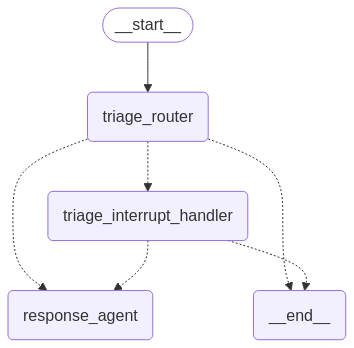

In [9]:
# Conditional edge function
def should_continue(state: State) -> Literal["interrupt_handler", END]:
    """Route to tool handler, or end if Done tool called"""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return END
            else:
                return "interrupt_handler"

# Build workflow
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("interrupt_handler", interrupt_handler)

# Add edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "interrupt_handler": "interrupt_handler",
        END: END,
    },
)
agent_builder.add_edge("interrupt_handler", "llm_call")

# Compile the agent
response_agent = agent_builder.compile()

# Build overall workflow
overall_workflow = (
    StateGraph(State, input=StateInput)
    .add_node(triage_router)
    .add_node(triage_interrupt_handler)
    .add_node("response_agent", response_agent)
    .add_edge(START, "triage_router")
    
)

email_assistant = overall_workflow.compile()
display(Image(email_assistant.get_graph().draw_mermaid_png()))

Now, we can test the workflow! 

## Accept `write_email` and `schedule_meeting`

This test simulates an email that gets classified as "respond" and the agent creates a schedule_meeting and write_email tool call that the user accepts.

In [20]:
import uuid

# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_1 = uuid.uuid4()
thread_config_1 = {"configurable": {"thread_id": thread_id_1}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2023-11-07', 'start_time': 14}}


Accept the `schedule_meeting` tool call

In [21]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2023-11-07', 'start_time': 14}} tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out. I have scheduled a call for us to discuss tax planning strategies on Tuesday, November 7th at 2:00 PM. The meeting is set for 45 minutes.\n\nLooking forward to our discussion and your suggestions.\n\nBest regards,\n\nLance Martin'}}


Accept the `write_email` tool call

In [22]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out. I have scheduled a call for us to discuss tax planning strategies on Tuesday, November 7th at 2:00 PM. The meeting is set for 45 minutes.\n\nLooking forward to our discussion and your suggestions.\n\nBest regards,\n\nLance Martin'}} tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_EPCwGSrxYpNduujTUZYI50Iw)
 Call ID: call_EPCwGSrxYpNduujTUZYI50Iw
  Args:
    done: True


Look at the full message history, and see trace:

https://smith.langchain.com/public/82277f96-3abd-48e0-a4db-413f7572240d/r

In [23]:
state = graph.get_state(thread_config_1)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_JULjapjWiBs3YBtccNpHqECR)
 Call ID: call_JULjapjWiBs3YBtccNpHqECR
  Args:
    day: 2023-11-07
  check_calendar_availability (call_3ljnPp3z5ZTmGJbqG9BTwzTM)
 Call ID: call_3ljnPp3z5ZTmGJbqG9BTwzTM
  Args:
    day: 2023-11-09
================================= Tool Message =================================

Ava

## Edit `write_email` and `schedule_meeting`

The agent creates a `schedule_meeting` and `write_email` tool call that the user edits.

In [15]:
# Same email as before
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph with new thread
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_2 = uuid.uuid4()
thread_config_2 = {"configurable": {"thread_id": thread_id_2}}

# Run the graph until the first interrupt - will be classified as "respond" and the agent will create a write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_2):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2023-11-07', 'start_time': 14}}


Edit the `schedule_meeting` tool call

In [16]:
# Now simulate user editing the schedule_meeting tool call
print("\nSimulating user editing the schedule_meeting tool call...")
edited_schedule_args = {
    "attendees": ["pm@client.com", "lance@company.com"],
    "subject": "Tax Planning Discussion",
    "duration_minutes": 30,  # Changed from 45 to 30
    "preferred_day": "Thursday",
    "start_time": 14 
}
for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_schedule_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user editing the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Hello,\n\nThank you for reaching out regarding tax planning strategies. I've scheduled a call for us on Thursday, November 9th, at 2:00 PM. We'll have 30 minutes to discuss your suggestions and explore potential savings.\n\nLooking forward to our conversation.\n\nBest regards,\n\nLance Martin"}}


Edit the `write_email` tool call

In [17]:
# Now simulate user editing the write_email tool call
print("\nSimulating user editing the write_email tool call...")
edited_email_args = {
    "to": "pm@client.com",
    "subject": "Re: Tax season let's schedule call",
    "content": "Hello Project Manager,\n\nThank you for reaching out about tax planning. I scheduled a 30-minute call next Thursday at 3:00 PM. Would that work for you?\n\nBest regards,\nLance Martin"
}
for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_email_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user editing the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_sdYc5FP1hzosXeIDmJWS53ov)
 Call ID: call_sdYc5FP1hzosXeIDmJWS53ov
  Args:
    done: True


Look at the full message history, and see trace, to view the edited tool calls:

https://smith.langchain.com/public/3ecbc07a-9a9f-4372-8f7e-f9c719e16e5d/r

In [18]:
state = graph.get_state(thread_config_2)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_wEkXtxd6IlJRFQ0TbQF09xlp)
 Call ID: call_wEkXtxd6IlJRFQ0TbQF09xlp
  Args:
    day: 2023-11-07
  check_calendar_availability (call_qQJRVonWvppB0BLngAPNdQ0e)
 Call ID: call_qQJRVonWvppB0BLngAPNdQ0e
  Args:
    day: 2023-11-09
================================= Tool Message =================================

Ava

## Ignore `write_email`, `schedule_meeting`, and `question`

This tests the user ignoring write_email, schedule_meeting, and question tool calls.

In [24]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_3 = uuid.uuid4()
thread_config_3 = {"configurable": {"thread_id": thread_id_3}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_3):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2023-11-07', 'start_time': 14}}


Ignore the `schedule_meeting` tool call

In [25]:
print(f"\nSimulating user ignoring the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "ignore"}]), config=thread_config_3):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user ignoring the {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2023-11-07', 'start_time': 14}} tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out regarding tax planning strategies. I am available for a call on Tuesday, November 7th at 2:00 PM for 45 minutes. Please let me know if this works for you.\n\nLooking forward to our discussion.\n\nBest regards,\n\nLance Martin'}}


Ignore the `write_email` tool call

In [26]:
print(f"\nSimulating user ignoring the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "ignore"}]), config=thread_config_3):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user ignoring the {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out regarding tax planning strategies. I am available for a call on Tuesday, November 7th at 2:00 PM for 45 minutes. Please let me know if this works for you.\n\nLooking forward to our discussion.\n\nBest regards,\n\nLance Martin'}} tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_Nfa4VFDOUbyiKdTY0ZzJMBZk)
 Call ID: call_Nfa4VFDOUbyiKdTY0ZzJMBZk
  Args:
    done: True


Look at the full message history, and see trace:

https://smith.langchain.com/public/06e22fef-160e-48ec-8c37-e4666a95afb2/r

We can see that agent does not create a meeting and does not write the email. 

In [27]:
state = graph.get_state(thread_config_3)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_juEXNt4Tu1pPd9FtLOHqDCmc)
 Call ID: call_juEXNt4Tu1pPd9FtLOHqDCmc
  Args:
    day: 2023-11-07
  check_calendar_availability (call_0E9N7EQ0k92iKZrjCrkKUUfI)
 Call ID: call_0E9N7EQ0k92iKZrjCrkKUUfI
  Args:
    day: 2023-11-09
================================= Tool Message =================================

Ava

Now let's try an email that calls the `Question` tool.

In [28]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Partner <partner@home.com>",
    "subject": "Meet Jim and Lisa for brunch in 3 weeks?",
    "email_thread": "Hey, should we invite Jim and Lisa to brunch in 3 weeks? We could go to the new place on 17th that everyone is talking about."
}

# Compile the graph
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_4 = uuid.uuid4()
thread_config_4 = {"configurable": {"thread_id": thread_id_4}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_4):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'Question', 'args': {'content': 'Do you have a specific date and time in mind for the brunch, or should I check our calendar for availability in three weeks?'}}


Ignore the `question` tool call

In [29]:
print(f"\nSimulating user ignoring the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "ignore"}]), config=thread_config_4):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user ignoring the {'action': 'Question', 'args': {'content': 'Do you have a specific date and time in mind for the brunch, or should I check our calendar for availability in three weeks?'}} tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'partner@home.com', 'subject': 'Re: Meet Jim and Lisa for brunch in 3 weeks?', 'content': 'Hi,\n\nI checked our calendar, and we are available for brunch on November 17th at 9:00 AM, 2:00 PM, or 4:00 PM. Let me know which time works best for you, and I can reach out to Jim and Lisa to see if they are available.\n\nLooking forward to it!\n\nBest,\nLance'}}


And just accept the `write_email` tool call

In [30]:
print(f"\nSimulating user ignoring the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_4):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user ignoring the {'action': 'write_email', 'args': {'to': 'partner@home.com', 'subject': 'Re: Meet Jim and Lisa for brunch in 3 weeks?', 'content': 'Hi,\n\nI checked our calendar, and we are available for brunch on November 17th at 9:00 AM, 2:00 PM, or 4:00 PM. Let me know which time works best for you, and I can reach out to Jim and Lisa to see if they are available.\n\nLooking forward to it!\n\nBest,\nLance'}} tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_LLLn4pbr9XYPEN9HvEWoOZ5I)
 Call ID: call_LLLn4pbr9XYPEN9HvEWoOZ5I
  Args:
    done: True


Look at the full message history, and see the trace. 

We can see agent proceeds without user input.

https://smith.langchain.com/public/8cf85d98-0418-469f-a3f4-d407e0315b5b/r

In [31]:
state = graph.get_state(thread_config_4)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Meet Jim and Lisa for brunch in 3 weeks?
**From**: Partner <partner@home.com>
**To**: Lance Martin <lance@company.com>

Hey, should we invite Jim and Lisa to brunch in 3 weeks? We could go to the new place on 17th that everyone is talking about.

---

================================== Ai Message ==================================
Tool Calls:
  Question (call_o1KzulY3brIQo2BzBiM6qeOW)
 Call ID: call_o1KzulY3brIQo2BzBiM6qeOW
  Args:
    content: Do you have a specific date and time in mind for the brunch, or should I check our calendar for availability in three weeks?
================================= Tool Message =================================

User ignored this question. Proceed with the context that you have and don't ask the user any more questions.
================================== Ai Message ==================================
Tool Calls:
  check_calendar_avail

## Respond (with feedback) `write_email`, `schedule_meeting`, and `question`

This tests the user responding to `write_email`, `schedule_meeting`, and `question` tool calls with feedback.

In [32]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_5 = uuid.uuid4()
thread_config_5 = {"configurable": {"thread_id": thread_id_5}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2023-11-07', 'start_time': 14}}


Provide feedback for the `schedule_meeting` tool call

In [33]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Please schedule this for 30 minutes instead of 45 minutes, and I prefer afternoon meetings after 2pm."}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user providing feedback for the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 30, 'preferred_day': '2023-11-07', 'start_time': 14}}


Accept the `schedule_meeting` tool call after providing feedback

In [34]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 30, 'preferred_day': '2023-11-07', 'start_time': 14}} tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Hello,\n\nThank you for reaching out regarding tax planning strategies. I've scheduled a call for us on Tuesday, November 7th, at 2:00 PM for 30 minutes. I look forward to discussing your suggestions and exploring potential savings.\n\nBest regards,\n\nLance Martin"}}


Now provide feedback for the `write_email` tool call

In [35]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Shorter and less formal. Include a closing statement about looking forward to the meeting!"}]), config=thread_config_5):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user providing feedback for the write_email tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Hi,\n\nI've set up a call for us on Tuesday, November 7th, at 2:00 PM for 30 minutes. Looking forward to hearing your suggestions!\n\nBest,\nLance"}}


Accept the `write_email` tool call after providing feedback

In [36]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Hi,\n\nI've set up a call for us on Tuesday, November 7th, at 2:00 PM for 30 minutes. Looking forward to hearing your suggestions!\n\nBest,\nLance"}} tool call...


Look at the full message history, and see the trace:

https://smith.langchain.com/public/57006770-6bb3-4e40-b990-143c373ebe60/r

We can see that user feedback in incorporated into the tool calls.  

In [37]:
state = graph.get_state(thread_config_5)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_U1A4PQ3qm49OJWYsXDc8Y2B6)
 Call ID: call_U1A4PQ3qm49OJWYsXDc8Y2B6
  Args:
    day: 2023-11-07
  check_calendar_availability (call_AYI8HMI4ukCmR1kGyCKbzkDG)
 Call ID: call_AYI8HMI4ukCmR1kGyCKbzkDG
  Args:
    day: 2023-11-09
================================= Tool Message =================================

Ava

Now let's try an email that calls the `Question` tool to provide feedback.

In [38]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Partner <partner@home.com>",
    "subject": "Meet Jim and Lisa for brunch in 3 weeks?",
    "email_thread": "Hey, should we invite Jim and Lisa to brunch in 3 weeks? We could go to the new place on 17th that everyone is talking about."
}

# Compile the graph
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_6 = uuid.uuid4()
thread_config_6 = {"configurable": {"thread_id": thread_id_6}}

# Run the graph until the first interrupt
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_6):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'Question', 'args': {'content': 'What day and time are you considering for the brunch in 3 weeks? I can check my calendar for availability and confirm.'}}


Provide feedback for the `Question` tool call

In [39]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Yes, let's invite them, but let me confirm which weekend works best. Also mention that we'll need to make a reservation since that place is popular."}]), config=thread_config_6):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user providing feedback for the Question tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'partner@home.com', 'subject': 'Re: Meet Jim and Lisa for brunch in 3 weeks?', 'content': "Hi,\n\nYes, let's definitely invite Jim and Lisa for brunch. I'll check my calendar to confirm which weekend works best for us. Also, since the new place on 17th is quite popular, we'll need to make a reservation in advance.\n\nI'll get back to you shortly with the details.\n\nBest,\nLance"}}


Accept the `write_email` tool call

In [40]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_6):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_9tqjOJ3AQHs0kTKBQWLc1YEK)
 Call ID: call_9tqjOJ3AQHs0kTKBQWLc1YEK
  Args:
    done: True


Look at the full message history, and see the trace:

https://smith.langchain.com/public/f4c727c3-b1d9-47a5-b3d0-3451619db8a2/r

We can see that user feedback in incorporated into the email response.

In [41]:
state = graph.get_state(thread_config_6)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Meet Jim and Lisa for brunch in 3 weeks?
**From**: Partner <partner@home.com>
**To**: Lance Martin <lance@company.com>

Hey, should we invite Jim and Lisa to brunch in 3 weeks? We could go to the new place on 17th that everyone is talking about.

---

================================== Ai Message ==================================
Tool Calls:
  Question (call_uIFMRcTx5hAX0Xc8LTD9eb0A)
 Call ID: call_uIFMRcTx5hAX0Xc8LTD9eb0A
  Args:
    content: What day and time are you considering for the brunch in 3 weeks? I can check my calendar for availability and confirm.
================================= Tool Message =================================

User answered the question, which can we can use for any follow up actions. Feedback: Yes, let's invite them, but let me confirm which weekend works best. Also mention that we'll need to make a reservation since that place is popul

## Test Case for Notify Classification

This test simulates an email that gets classified as "notify" and the user decides to respond with feedback.

In [42]:
# Notify - Important FYI Email
email_input_notify = {
    "to": "Team Members <team@company.com>",
    "author": "IT Department <it@company.com>",
    "subject": "Critical Security Update",
    "email_thread": "Dear Team,\n\nThis is an important security notification. We will be updating our authentication system this weekend. During the update window (Saturday 2am-4am), you will not be able to access company resources.\n\nPlease ensure you log out of all systems before the maintenance window.\n\nRegards,\nIT Department"
}

# Compile the graph with new thread
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_7 = uuid.uuid4()
thread_config_7 = {"configurable": {"thread_id": thread_id_7}}

# Run the graph until the first interrupt - should be classified as "notify"
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_notify}, config=thread_config_7):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
🔔 Classification: NOTIFY - This email contains important information

INTERRUPT OBJECT:
Action Request: {'action': 'Email Assistant: notify', 'args': {}}


Now simulate user deciding to respond with feedback.

In [43]:
print("\nSimulating user deciding to respond with feedback...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "We should acknowledge receipt of this important notice and confirm that we'll be logged out before the maintenance window."}]), config=thread_config_7):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user deciding to respond with feedback...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'it@company.com', 'subject': 'Re: Critical Security Update', 'content': 'Dear IT Department,\n\nThank you for the important security update notification. I acknowledge receipt of this notice and will ensure that I am logged out of all systems before the maintenance window begins.\n\nBest regards,\nLance'}}


Accept the `write_email` tool call after feedback.

In [44]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_7):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'write_email', 'args': {'to': 'it@company.com', 'subject': 'Re: Critical Security Update', 'content': 'Dear IT Department,\n\nThank you for the important security update notification. I acknowledge receipt of this notice and will ensure that I am logged out of all systems before the maintenance window begins.\n\nBest regards,\nLance'}} tool call...


Look at the full message history, and see the trace:

https://smith.langchain.com/public/6594f98f-eb83-4560-9c34-28ec22ada3dc/r

We can see that user feedback causes agent to go reply to the email.

In [45]:
state = graph.get_state(thread_config_7)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Email to notify user about: 

**Subject**: Critical Security Update
**From**: IT Department <it@company.com>
**To**: Team Members <team@company.com>

Dear Team,

This is an important security notification. We will be updating our authentication system this weekend. During the update window (Saturday 2am-4am), you will not be able to access company resources.

Please ensure you log out of all systems before the maintenance window.

Regards,
IT Department

---

================================ Human Message =================================

User wants to reply to the email. Use this feedback to respond: We should acknowledge receipt of this important notice and confirm that we'll be logged out before the maintenance window.
================================== Ai Message ==================================
Tool Calls:
  write_email (call_0YzR0aORrsTua5qZu6I3NjU4)
 Call ID: call_0YzR0aORrsTua5qZu6I3NjU4
  Args

## Test Case for Notify + Ignore

This test simulates an email that gets classified as "notify" and the user decides to ignore it.

In [ ]:
# Notify - Important FYI Email
email_input_notify = {
    "to": "Team Members <team@company.com>",
    "author": "HR Department <hr@company.com>",
    "subject": "Company Picnic Next Month",
    "email_thread": "Dear Team,\n\nWe're planning the annual company picnic for next month. The tentative date is Saturday, June 15th from noon to 4pm at Central Park. There will be food, games, and activities for families.\n\nMore details will follow in the coming weeks.\n\nRegards,\nHR Department"
}

# Compile the graph with new thread
checkpointer = MemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_8 = uuid.uuid4()
thread_config_8 = {"configurable": {"thread_id": thread_id_8}}

# Run the graph until the first interrupt - should be classified as "notify"
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_notify}, config=thread_config_8):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Now simulate user deciding to ignore the notification.

In [ ]:
print("\nSimulating user deciding to ignore the notification...")
for chunk in graph.stream(Command(resume=[{"type": "ignore"}]), config=thread_config_8):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Look at the full message history.

In [ ]:
state = graph.get_state(thread_config_8)
for m in state.values['messages']:
    m.pretty_print()

## Testing with Local Deployment

You can find this graph in the `src/email_assistant` directory:

* `src/email_assistant/email_assistant_hitl.py`

You can test it locally in LangGraph Studio by running:

In [ ]:
! langgraph dev

Example e-mail you can test:

In [ ]:
email_input = {
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}

When you submit the e-mail, you will see the interrupt in Studio. This displays the full `request` object that was passed to the `interrupt` function.

![studio-img](img/studio-interrupt.png)
 
If you go to [dev.agentinbox.ai](https://dev.agentinbox.ai/), you can add the graph url:
   * Graph name: the name from the `langgraph.json` file (`email_assistant_hitl`)
   * Graph URL: `http://127.0.0.1:2024/`

All interrupted threads run will be visible. Any e-mail triaged to `Notify` will be displayed in Agent Inbox with the action request in `triage_interrupt_handler`, allowing you to ignore or respond with feedback. In addition, any email marked with `Respond` will be displayed in Agent Inbox with the action request in `interrupt_handler`, allowing you to review tool calls from `["write_email", "schedule_meeting", "Question"]`.

![agent-inbox-img](img/agent-inbox.png)

In the case of `write_email`, you can fully edit the e-mail content, accept it as-is, ignore it, or provide feedback as specified in the `config` argument:

In [ ]:
config = {
    "allow_ignore": True,
    "allow_respond": True,
    "allow_edit": True,
    "allow_accept": True,
}

![agent-inbox-img](img/agent-inbox-draft.png)